# Risk-Aware Q Learning
* Reward shaping to penalize drawdown and streaks
* Track bankroll, volatility, and behavior
* Compare to Flat Betting baseline
* Evaluate long-term performanc

In [2]:
# Core imports
import sys
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import deque
from typing import Dict, Tuple

# Enable module imports from project root if needed
sys.path.append("..")  # or "." if already in project root

# Style
sns.set(style="whitegrid")


In [3]:
# Risk-aware Roulette environment

from config import BET_LIMITS, PAYOUTS
from utils import spin_wheel, is_red, is_black, is_even, is_odd, is_high, is_low

class RiskAwareRouletteEnv:
    def __init__(self, starting_bankroll=1000):
        self.starting_bankroll = starting_bankroll
        self.reset()

    def reset(self):
        self.bankroll = self.starting_bankroll
        self.peak_bankroll = self.starting_bankroll
        self.history = []
        self.round = 0
        self.win_streak = 0
        self.loss_streak = 0
        return self.get_state()

    def get_state(self):
        return {
            "bankroll": self.bankroll,
            "drawdown": self.peak_bankroll - self.bankroll,
            "last_win": self.history[-1]["win"] if self.history else None,
            "win_streak": self.win_streak,
            "loss_streak": self.loss_streak
        }

    def step(self, action: Dict) -> Tuple[Dict, float, bool, Dict]:
        self.round += 1

        if self.bankroll < BET_LIMITS["outside"]["min"]:
            return self.get_state(), -100.0, True, {"bankrupt": True}

        outcome = spin_wheel()
        win = self.evaluate(action, outcome)
        payout = action["amount"] * PAYOUTS[action["type"]] if win else -action["amount"]
        self.bankroll += payout
        self.peak_bankroll = max(self.peak_bankroll, self.bankroll)

        # Update streaks
        if win:
            self.win_streak += 1
            self.loss_streak = 0
        else:
            self.loss_streak += 1
            self.win_streak = 0

        # Record
        self.history.append({
            "round": self.round,
            "outcome": outcome,
            "bet": action,
            "win": win,
            "payout": payout,
            "bankroll": self.bankroll
        })

        # 🎯 Reward shaping for risk control
        reward = payout

        # Penalty for excessive drawdown
        drawdown = self.peak_bankroll - self.bankroll
        if drawdown > self.starting_bankroll * 0.5:
            reward -= 100

        # Bonus for reaching 1.5x bankroll
        if self.bankroll > self.starting_bankroll * 1.5:
            reward += 50

        # Bonus for surviving
        if self.round % 100 == 0:
            reward += 10

        # Small penalty for extended losing streaks
        if self.loss_streak >= 5:
            reward -= 25

        done = self.bankroll < BET_LIMITS["outside"]["min"] or self.round >= 1000
        return self.get_state(), reward, done, {"outcome": outcome, "win": win, "payout": payout}

    def evaluate(self, action, outcome):
        if action["type"] == "red":
            return is_red(outcome)
        elif action["type"] == "black":
            return is_black(outcome)
        elif action["type"] == "odd":
            return is_odd(outcome)
        elif action["type"] == "even":
            return is_even(outcome)
        elif action["type"] == "high":
            return is_high(outcome)
        elif action["type"] == "low":
            return is_low(outcome)
        elif action["type"] == "straight":
            return outcome == action["target"]
        return False


In [4]:
# Risk-aware state encoder

def encode_state_riskaware(state, bankroll_bin_size=100, drawdown_bin_size=100):
    bankroll_bin = min(int(state["bankroll"] // bankroll_bin_size), 20)  # Cap at $2000+
    drawdown_bin = min(int(state["drawdown"] // drawdown_bin_size), 20)  # Cap at $2000+

    last_win = 1 if state.get("last_win") else 0
    win_streak = min(state.get("win_streak", 0), 3)   # Cap at 3+
    loss_streak = min(state.get("loss_streak", 0), 5) # Cap at 5+

    return (bankroll_bin, drawdown_bin, last_win, win_streak, loss_streak)


In [5]:
# Action space for risk-aware agent

# Outside bets (self-contained: "target" is same as "type")
OUTSIDE_BETS = ["red", "black", "even", "odd", "high", "low"]
outside_actions = [{"type": b, "target": b} for b in OUTSIDE_BETS]

# Inside straight bets on numbers 0–36
STRAIGHT_NUMBERS = list(range(37))
inside_actions = [{"type": "straight", "target": n} for n in STRAIGHT_NUMBERS]

# Full action space (fixed amount applied later)
ACTIONS = outside_actions + inside_actions
ACTION_SPACE_SIZE = len(ACTIONS)

# Fixed bet amount (used throughout)
fixed_bet_amount = 20


In [6]:
# Q-learning training for risk-aware agent

# Q-table initialization
Q = {}

# Hyperparameters
alpha = 0.1         # Learning rate
gamma = 0.95        # Discount factor
epsilon = 1.0       # Exploration rate
min_epsilon = 0.1
epsilon_decay = 0.995

episodes = 1000
max_steps = 1000

# Tracking
episode_rewards = []
episode_lengths = []

for ep in range(episodes):
    env = RiskAwareRouletteEnv(starting_bankroll=1000)
    state = encode_state_riskaware(env.reset())
    total_reward = 0

    for step in range(max_steps):
        # Initialize state in Q-table
        if state not in Q:
            Q[state] = np.zeros(ACTION_SPACE_SIZE)

        # Choose action (epsilon-greedy)
        if random.random() < epsilon:
            action_idx = random.randint(0, ACTION_SPACE_SIZE - 1)
        else:
            action_idx = int(np.argmax(Q[state]))

        action = ACTIONS[action_idx].copy()
        action["amount"] = fixed_bet_amount

        next_state_raw, reward, done, _ = env.step(action)
        next_state = encode_state_riskaware(next_state_raw)

        if next_state not in Q:
            Q[next_state] = np.zeros(ACTION_SPACE_SIZE)

        # Q-learning update
        Q[state][action_idx] += alpha * (
            reward + gamma * np.max(Q[next_state]) - Q[state][action_idx]
        )

        state = next_state
        total_reward += reward

        if done:
            break

    # Decay exploration
    epsilon = max(min_epsilon, epsilon * epsilon_decay)

    episode_rewards.append(total_reward)
    episode_lengths.append(step + 1)

    if (ep + 1) % 100 == 0:
        print(f"Episode {ep+1}/{episodes} | Reward: {total_reward:.2f} | Steps: {step+1} | Epsilon: {epsilon:.3f}")


Episode 100/1000 | Reward: -48435.00 | Steps: 982 | Epsilon: 0.606
Episode 200/1000 | Reward: -5225.00 | Steps: 76 | Epsilon: 0.367
Episode 300/1000 | Reward: -8465.00 | Steps: 108 | Epsilon: 0.222
Episode 400/1000 | Reward: -42835.00 | Steps: 902 | Epsilon: 0.135
Episode 500/1000 | Reward: -13655.00 | Steps: 204 | Epsilon: 0.100
Episode 600/1000 | Reward: -15580.00 | Steps: 278 | Epsilon: 0.100
Episode 700/1000 | Reward: -14130.00 | Steps: 264 | Epsilon: 0.100
Episode 800/1000 | Reward: -34685.00 | Steps: 1000 | Epsilon: 0.100
Episode 900/1000 | Reward: -15255.00 | Steps: 232 | Epsilon: 0.100
Episode 1000/1000 | Reward: -23120.00 | Steps: 1000 | Epsilon: 0.100


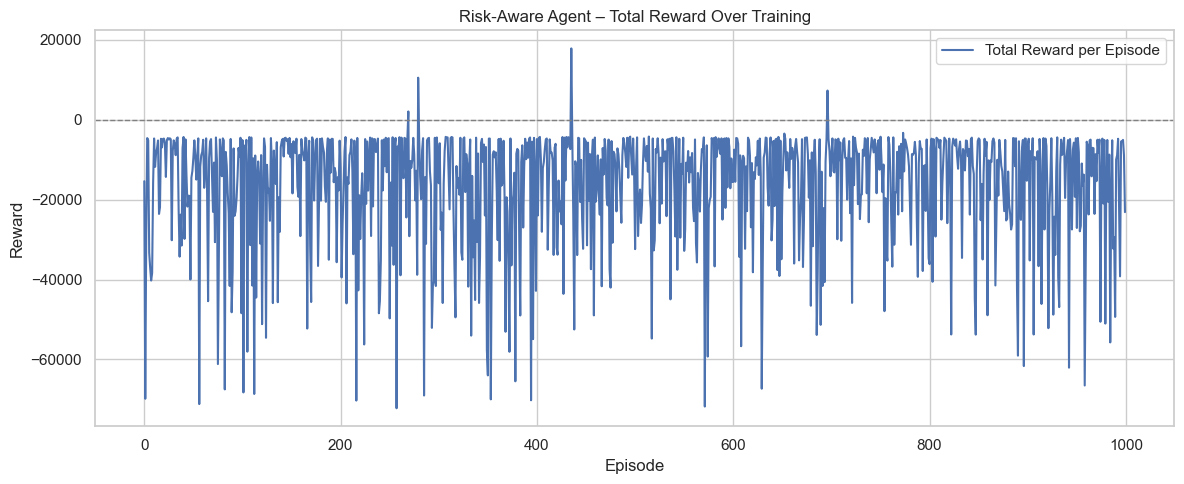

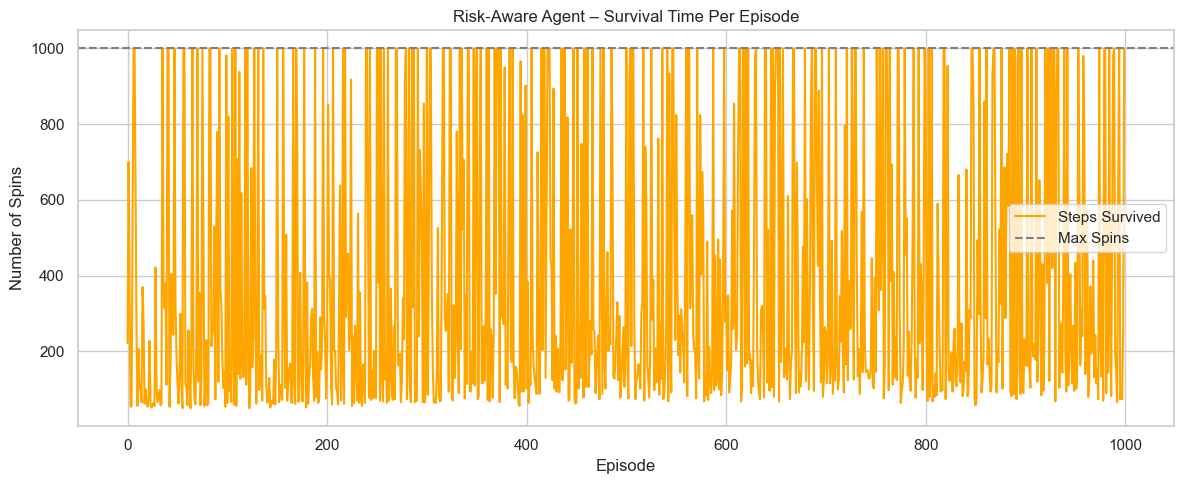

In [7]:
# Visualize learning curves
plt.figure(figsize=(12, 5))
plt.plot(episode_rewards, label="Total Reward per Episode")
plt.axhline(0, color="gray", linestyle="--", linewidth=1)
plt.title("Risk-Aware Agent – Total Reward Over Training")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(episode_lengths, label="Steps Survived", color="orange")
plt.axhline(y=1000, color='gray', linestyle='--', label="Max Spins")
plt.title("Risk-Aware Agent – Survival Time Per Episode")
plt.xlabel("Episode")
plt.ylabel("Number of Spins")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### evaluate agent

In [10]:
# Evaluate risk-aware agent with greedy policy

def evaluate_agent(agent_policy_fn, label, runs=100):
    rewards = []
    spins = []

    for _ in range(runs):
        env = RiskAwareRouletteEnv()
        state = encode_state_riskaware(env.reset())
        total_reward = 0
        count = 0
        done = False

        while not done:
            action_idx = agent_policy_fn(state)
            action = ACTIONS[action_idx].copy()
            action["amount"] = fixed_bet_amount
            next_state_raw, reward, done, _ = env.step(action)
            state = encode_state_riskaware(next_state_raw)
            total_reward += reward
            count += 1

        rewards.append(total_reward)
        spins.append(count)

    return pd.DataFrame({
        "Strategy": label,
        "Reward": rewards,
        "Spins": spins
    })

# Risk-aware policy: greedy from Q-table
def riskaware_policy(state):
    if state not in Q:
        return random.randint(0, ACTION_SPACE_SIZE - 1)
    return int(np.argmax(Q[state]))

# Flat policy (baseline)
def flat_policy(state):
    return 0  # Assumes ACTIONS[0] is 'red'

# Run evaluations
df_riskaware = evaluate_agent(riskaware_policy, "Risk-Aware Agent")
df_flat = evaluate_agent(flat_policy, "Flat Betting")

# Combine for summary
df_eval = pd.concat([df_riskaware, df_flat])
df_eval


,Strategy,Reward,Spins
0,Risk-Aware Agent,-8240,176
1,Risk-Aware Agent,-35240,1000
2,Risk-Aware Agent,-5165,106
3,Risk-Aware Agent,-8615,180
4,Risk-Aware Agent,-20760,450
...,...,...,...
95,Flat Betting,-22320,336
96,Flat Betting,-39840,632
97,Flat Betting,-25950,508
98,Flat Betting,-37880,756


C:\Users\JR\AppData\Local\Temp\ipykernel_13916\1820245655.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_eval, x="Strategy", y="Reward", palette="Set2")


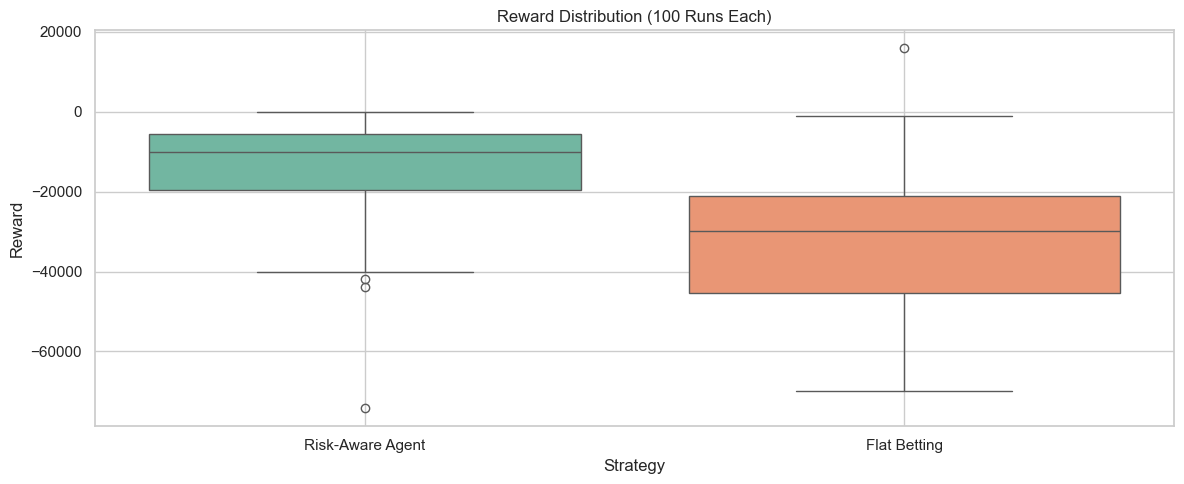

C:\Users\JR\AppData\Local\Temp\ipykernel_13916\1820245655.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_eval, x="Strategy", y="Spins", palette="Set3")


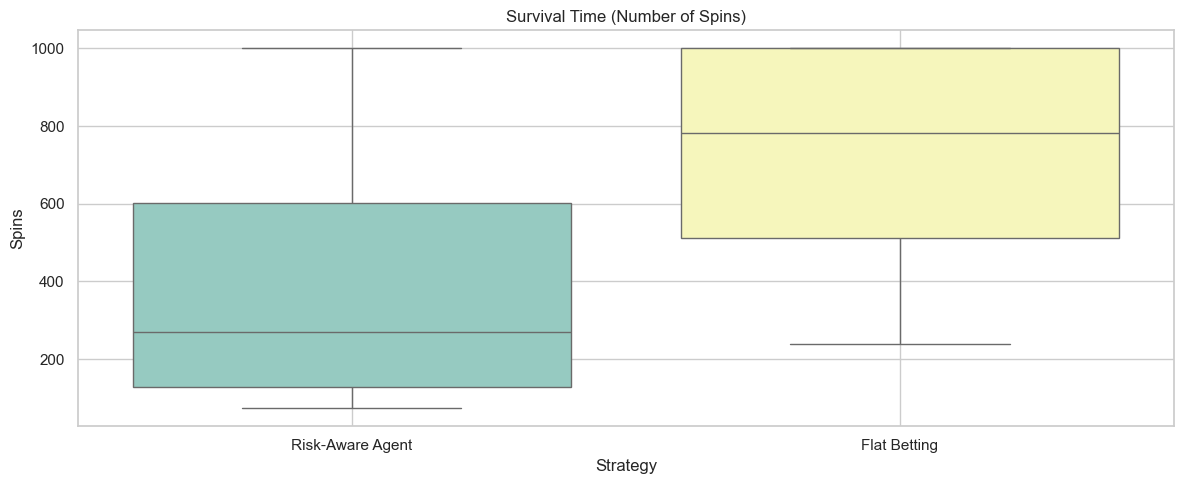

In [11]:
# Reward distribution
plt.figure(figsize=(12, 5))
sns.boxplot(data=df_eval, x="Strategy", y="Reward", palette="Set2")
plt.title("Reward Distribution (100 Runs Each)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Spins survived
plt.figure(figsize=(12, 5))
sns.boxplot(data=df_eval, x="Strategy", y="Spins", palette="Set3")
plt.title("Survival Time (Number of Spins)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
summary_table = (
    df_eval.groupby("Strategy")
    .agg(
        Reward_Mean=("Reward", "mean"),
        Reward_Median=("Reward", "median"),
        Reward_Std=("Reward", "std"),
        Reward_Min=("Reward", "min"),
        Reward_Max=("Reward", "max"),
        Spins_Mean=("Spins", "mean"),
        Spins_Median=("Spins", "median")
    )
    .round(2)
)

summary_table


,Reward_Mean,Reward_Median,Reward_Std,Reward_Min,Reward_Max,Spins_Mean,Spins_Median
Strategy,,,,,,,
Flat Betting,-32660.65,-29917.5,16111.93,-69995,15890,734.46,782.0
Risk-Aware Agent,-14300.00,-9977.5,11656.67,-74195,-135,404.18,270.0


In [13]:
# % of runs where Reward > 0
percent_profitable = (
    df_eval.assign(Profitable=df_eval["Reward"] > 0)
    .groupby("Strategy")["Profitable"]
    .mean()
    .mul(100)
    .round(2)
    .rename("Percent Profitable")
)

percent_profitable


Strategy
Flat Betting        1.0
Risk-Aware Agent    0.0
Name: Percent Profitable, dtype: float64